# Tutorial 2 - Segmentation

In this tutorial, we will develop a CNN model for image segmentation. The structure of the code is similar to the one for image classification, but with some specific changes due to the different task. This time we are using real-world clinical data from a chest radiography dataset called JSRT. We consider a four class image segmentation taks involving the segmentation of the heart and the lungs.

**Objective:** Implement a fully convolutional neural network such as U-net for semantic segmentation of chest radiography images.

In [1]:
# On Google Colab uncomment the following line to install PyTorch Lightning
# ! pip install lightning

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib
import matplotlib.pyplot as plt

from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torchmetrics.functional import dice
from sklearn.model_selection import train_test_split
from skimage.io import imread
from tqdm import tqdm

## Data

We need to download and extract the JSRT chest radiography dataset.

In [3]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/JSRT.zip
! unzip JSRT.zip

--2024-02-12 22:00:50--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/JSRT.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5516125 (5.3M) [application/zip]
Saving to: ‘JSRT.zip.1’

JSRT.zip.1          100%[===================>]   5.26M  14.2MB/s    in 0.4s    

2024-02-12 22:00:50 (14.2 MB/s) - ‘JSRT.zip.1’ saved [5516125/5516125]

Archive:  JSRT.zip
replace data/JSRT/images/JPCLN001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Let's visualise a random test image

Text(0.5, 1.0, 'labelmap')

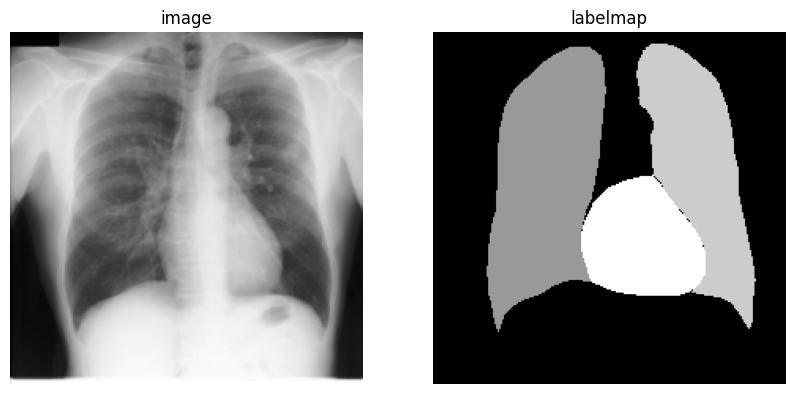

In [4]:
image = imread('data/JSRT/images/JPCLN001.png')
labelmap = imread('data/JSRT/masks/JPCLN001.png')

f, ax = plt.subplots(1,2, figsize=(10, 10))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('image')

ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('labelmap')

We provide a custom [PyTorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) that loads and processes the JSRT dataset.

In [6]:
class JSRTDataset(Dataset):
    def __init__(self, data: pd.DataFrame, data_dir: str, augmentation: bool = False):
        self.data = data.reset_index(drop=True)
        self.data_dir = data_dir        
        self.do_augment = augmentation

        # photometric data augmentation
        self.photometric_augment = transforms.Compose([
            transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
        ])

        # geometric data augmentation
        self.geometric_augment = transforms.Compose([
            transforms.RandomApply(transforms=[transforms.RandomAffine(degrees=5, scale=(0.9, 1.1), interpolation=transforms.InterpolationMode.NEAREST)], p=0.5),
        ])

        # collect samples (file paths) from dataset
        self.samples = []
        for idx, _ in enumerate(tqdm(range(len(self.data)), desc='Loading Data')):
            img_path = os.path.join(self.data_dir, 'images', self.data.loc[idx, 'study_id'])
            lab_path = os.path.join(self.data_dir, 'masks', self.data.loc[idx, 'study_id'])

            sample = {'image_path': img_path, 'labelmap_path': lab_path}
            self.samples.append(sample)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample = self.get_sample(item)

        # conver to torch tensors and add batch dimension
        image = torch.from_numpy(sample['image']).unsqueeze(0)
        labelmap = torch.from_numpy(sample['labelmap']).unsqueeze(0)

        # apply data augmentation
        if self.do_augment:
            image = self.photometric_augment(image.type(torch.ByteTensor)).type(torch.FloatTensor)
            
            # Stack the image and mask together so they get the same geometric transformations
            stacked = torch.cat([image, labelmap], dim=0)  # shape=(2xHxW)
            stacked = self.geometric_augment(stacked)

            # Split them back up again and convert labelmap back to datatype long
            image, labelmap = torch.chunk(stacked, chunks=2, dim=0)
            labelmap = labelmap.type(torch.LongTensor)

        # normalize image intensities to [0,1]
        image /= 255

        return {'image': image, 'labelmap': labelmap}

    def get_sample(self, item):
        sample = self.samples[item]
        
        # read image and labelmap from disk
        image = imread(sample['image_path']).astype(np.float32)
        labelmap = imread(sample['labelmap_path']).astype(np.int64)

        # convert labelmap to consecutive labels
        labelmap[labelmap==250] = 1 # heart
        labelmap[labelmap==200] = 2 # left lung
        labelmap[labelmap==150] = 3 # right lung
        labelmap[labelmap>3] = 0 # background

        return {'image': image, 'labelmap': labelmap}

We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling the JSRT dataset.

In [7]:
class JSRTDataModule(LightningDataModule):
    def __init__(self, data_dir: str = './data/JSRT', batch_size: int = 5):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.data = pd.read_csv(os.path.join(self.data_dir,'jsrt_metadata.csv'))
        dev, self.test_data = train_test_split(self.data, test_size=0.2)
        self.train_data, self.val_data = train_test_split(dev, test_size=0.05)
        
        self.train_set = JSRTDataset(self.train_data, self.data_dir, augmentation=True)
        self.val_set = JSRTDataset(self.val_data, self.data_dir, augmentation=False)
        self.test_set = JSRTDataset(self.test_data, self.data_dir, augmentation=False)

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

## Model

We use a [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) for implementing the model and its training and testing steps.

**Task:** Replace the single-layer network with a U-net-like CNN architecture. You need to add the model layers and change the forward pass accordingly.

In [8]:
class ImageSegmenter(LightningModule):
    def __init__(self, output_dim: int, learning_rate: float = 0.001):
        super().__init__()
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.test_probmaps = []
        self.test_predmaps = []

        # define network layers
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)

        self.down1 = nn.Conv2d(8, 8, kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        
        self.down2 = nn.Conv2d(16, 16, kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

        self.conv8 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        self.up2 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)

        self.conv10 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(8, self.output_dim, kernel_size=3, padding=1)


    def forward(self, x):        
        x1 = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x1))
        
        x2 = self.down1(x1)
        x2 = F.relu(self.conv3(x2))
        x2 = F.relu(self.conv4(x2))
        
        x3 = self.down2(x2)
        x3 = F.relu(self.conv5(x3))
        x3 = F.relu(self.conv6(x3))
        x3 = F.relu(self.conv7(x3))

        x2 = self.up1(x3) + x2
        x2 = F.relu(self.conv8(x2))
        x2 = F.relu(self.conv9(x2))

        x1 = self.up2(x2) + x1
        x1 = F.relu(self.conv10(x1))
        return self.conv11(x1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def process_batch(self, batch):
        x, y = batch['image'], batch['labelmap']
        logits = self(x)
        loss = F.cross_entropy(logits, y.squeeze())

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        dsc = dice(preds, y.squeeze(), average='macro', num_classes=self.output_dim, ignore_index=0)
        
        return loss, dsc, probs, preds

    def training_step(self, batch, batch_idx):
        loss, dsc, probs, preds = self.process_batch(batch)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_dice", dsc, prog_bar=True)
        
        if batch_idx == 0:
            grid = torchvision.utils.make_grid(batch['image'][0:4, ...], nrow=2, normalize=True)
            self.logger.experiment.add_image('train_images', grid, self.global_step)

            grid = torchvision.utils.make_grid(batch['labelmap'][0:4, ...].type('torch.FloatTensor'), nrow=2, normalize=True)
            self.logger.experiment.add_image('train_labelmaps', grid, self.global_step)

            grid = torchvision.utils.make_grid(probs[0:4, 1:4, ...], nrow=2, normalize=True)
            self.logger.experiment.add_image('train_probmaps', grid, self.global_step)
        
            grid = torchvision.utils.make_grid(preds[0:4, ...].unsqueeze(1).type('torch.FloatTensor'), nrow=2, normalize=True)
            self.logger.experiment.add_image('train_predmaps', grid, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, dsc, _, _ = self.process_batch(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_dice", dsc, prog_bar=True)

    def on_test_start(self):
        self.test_probmaps = []
        self.test_predmaps = []
    
    def test_step(self, batch, batch_idx):
        loss, dsc, probs, preds = self.process_batch(batch)
        self.log("test_loss", loss)
        self.log("test_dice", dsc)
        self.test_probmaps.append(probs)
        self.test_predmaps.append(preds)

## Training

We use the PyTorch Lightning [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) for training and testing.

In [9]:
seed_everything(42, workers=True)

data = JSRTDataModule(data_dir='./data/JSRT', batch_size=5)

model = ImageSegmenter(output_dim=4, learning_rate=0.001)

trainer = Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    log_every_n_steps=5,
    logger=TensorBoardLogger(save_dir='./lightning_logs/segmentation/', name='jsrt-single-conv'),
    callbacks=[ModelCheckpoint(monitor="val_loss", mode='min'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

Seed set to 42
Loading Data: 100%|██████████| 50/50 [00:00<00:00, 59426.24it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: ./lightning_logs/segmentation/jsrt-single-conv
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name   | Type            | Params
--------------------------------------------
0  | conv1  | Conv2d          | 40    
1  | conv2  | Conv2d          | 296   
2  | down1  | Conv2d          | 264   
3  | conv3  | Conv2d          | 584   
4  | conv4  | Conv2d          | 1.2 K 
5

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/avzh1/Documents/imperial/year4/lectures/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


/home/avzh1/Documents/imperial/year4/lectures/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 38/38 [00:01<00:00, 30.49it/s, v_num=0, train_loss=0.126, train_dice=0.932, val_loss=0.134, val_dice=0.911]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 38/38 [00:01<00:00, 30.44it/s, v_num=0, train_loss=0.126, train_dice=0.932, val_loss=0.134, val_dice=0.911]


## Validation

Evaluate the trained model with the best checkpoint on the validation data and report the segmentation performance.

In [10]:
trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at ./lightning_logs/segmentation/jsrt-single-conv/version_0/checkpoints/epoch=42-step=1634.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/segmentation/jsrt-single-conv/version_0/checkpoints/epoch=42-step=1634.ckpt


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 55.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_dice            0.9143873453140259
        val_loss            0.12694904208183289
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.12694904208183289, 'val_dice': 0.9143873453140259}]

## Testing

Evaluate the trained model with the best checkpoint on the test data and report the segmentation performance.

In [11]:
trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at ./lightning_logs/segmentation/jsrt-single-conv/version_0/checkpoints/epoch=42-step=1634.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/segmentation/jsrt-single-conv/version_0/checkpoints/epoch=42-step=1634.ckpt
/home/avzh1/Documents/imperial/year4/lectures/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 49.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_dice           0.8935599327087402
        test_loss           0.15674534440040588
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.15674534440040588, 'test_dice': 0.8935599327087402}]

## Visualisation

Let's visualise the segmentation result for a random test image.

Text(0.5, 1.0, 'probability map')

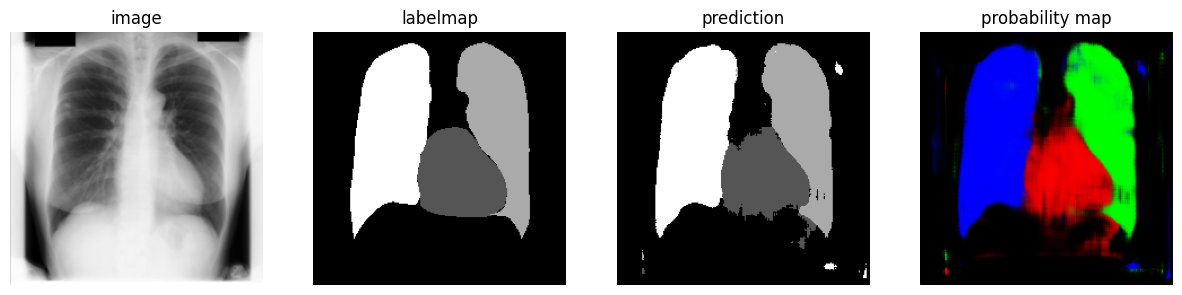

In [12]:
test_sample = data.test_set[0]
image = test_sample['image'].squeeze()
labelmap = test_sample['labelmap'].squeeze()
probmap = np.moveaxis(model.test_probmaps[0][0,1:4,...].cpu().numpy(), 0, -1)
predmap = model.test_predmaps[0][0,...].cpu().numpy()

f, ax = plt.subplots(1,4, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('image')

ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('labelmap')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('prediction')

ax[3].imshow(probmap, cmap=matplotlib.cm.bwr)
ax[3].axis('off')
ax[3].set_title('probability map')

## Logging

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './lightning_logs/segmentation/'